# Logistic Regression

### Import libraries

In [36]:
import pandas as pd # one-hot encoding
import numpy as np
import glob
import os

import matplotlib.pyplot as plt # graphs
import matplotlib.colors as colors

import joblib
import datetime

from collections import defaultdict

import sklearn
from sklearn.utils import resample # downsample dataset
from sklearn.model_selection import train_test_split # split to training and testing datasets
from sklearn.model_selection import GridSearchCV # cross validation
#from sklearn.preprocessing import scale # scale and center data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

### Import data

In [37]:
corpus = pd.read_csv("../dataset/dataset.csv")
corpus.head()

,CONTENT,CLASS
0,"*Despite the economic downturn,I'm so happy☺️....",1
1,"Hey Olaf, You better talk nice or the U.S. blo...",1
2,"Hey Olaf, You better talk nice or the U.S. blo...",1
3,"Hey Olaf, You better talk nice or the U.S. blo...",1
4,"Hey Olaf, You better talk nice or the U.S. blo...",1


### Statistics about the data

In [ ]:
#print(f"Data types:\n{corpus.dtypes}\n")
print(f"There are {len(corpus['CLASS'].unique())} comment types: {corpus['CLASS'].unique()}")
print(f"The dataset contains of {len(corpus)} examples: {len(corpus.loc[corpus['CLASS'] == 1])} spam and {len(corpus.loc[corpus['CLASS'] == 0])} legitimate comments")

corpus.groupby("CLASS").CONTENT.count().plot.bar(ylim=0)
plt.xticks([0,1],['legitimate', 'spam'], rotation=0)
plt.xlabel("comment type")
plt.ylabel("numberof comments")
plt.title("Dataset distribution", pad=20)
plt.show()

In [38]:
#nltk.download('stopwords')
#nltk.download('omw-1.4')
    
def preprocess_data(corpus):

    # remove blank rows if any
    corpus.dropna(inplace=True)
    
    # add column for representation
    corpus['REPR'] = corpus.loc[:, 'CONTENT']
        
    # lower case
    corpus['REPR'] = corpus['REPR'].str.lower()

    # change column name
    #for old, new in rename_columns:
        #corpus.rename({old : new}, axis=1, inplace=True)

    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    
    for comment in corpus["REPR"]:    
        comment = nltk.word_tokenize(comment) # tokenizing nltk.WordPunctTokenizer().tokenize(comment.lower())?
        comment = [lemmatizer.lemmatize(word) for word in comment] # lemmatizing
        comment = [word for word in comment if word not in stop_words] # removing stopwords
        comment = " ".join(comment)

In [39]:
preprocess_data(corpus)

# binary feature representation
vectorizer = CountVectorizer(binary=True, max_df=0.95) #max_features=10000, tokenizer=lambda doc: doc)
BOW = vectorizer.fit_transform(corpus["REPR"])

# count based feature representation
vectorizer_2 = CountVectorizer(binary=False, max_df=0.95) #max_features=10000)
BOW_2 = vectorizer_2.fit_transform(corpus["REPR"])

# bag of 2-Grams
bigram_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
BOW_3 = bigram_vectorizer.fit_transform(corpus["REPR"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95) #min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
tfidf_voc = tfidf_vectorizer.fit_transform(corpus["REPR"])

### Logistic Regression model

### Train, store and evaluate

In [40]:

def split_data(features, labels):
    return train_test_split(features,labels, test_size=0.3,random_state=42,shuffle=True)


def save_model(model):
    now = datetime.datetime.now()
    model_output_path = "saved_models/"+model.__class__.__name__.lower()+"_"+str(now.minute)+"-"+str(now.second)+".joblib"
    joblib.dump(model, open(model_output_path, 'wb+'))


def report(model, best_model, X_test, y_test, labels):
    print(f"Best parameters set {model.best_params_} with accuracy {model.best_score_}")
    y_predict = best_model.predict(X_test)
    
    labels = sorted(list(set(labels)))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, y_predict, labels=labels) # lables=clf.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))
    
    print("\nAccuracy: {}%".format(accuracy_score(y_test, y_predict)*100))
    print("Precision: {}%".format(sklearn.metrics.precision_score(y_test, y_predict)*100))
    print("Recall: {}%".format(sklearn.metrics.recall_score(y_test, y_predict)*100))

    
def train_lg_classifier(features, labels):
    # split data
    X_train, X_test, y_train, y_test = split_data(features, labels)

    param = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

    clf = GridSearchCV(LogisticRegression(), param, cv=5, n_jobs=2, verbose=0)
    
    clf.fit(X_train, y_train)
    lg_clf = clf.best_estimator_
    
    # save model to disk
    save_model(lg_clf)
    
    # show test report
    report(clf, lg_clf, X_test, y_test, labels)


/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Best parameters set {'C': 100.0} with accuracy 0.9371525453700006

Confusion matrix:


/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


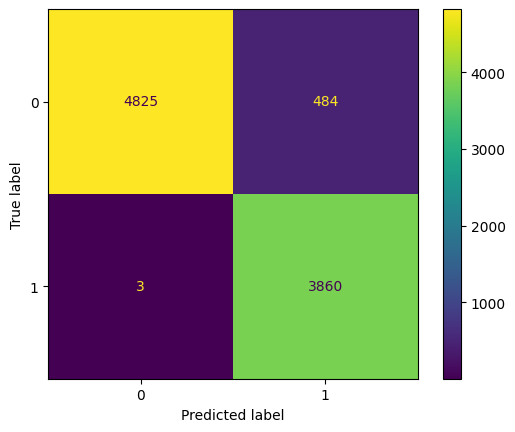


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5309
           1       0.89      1.00      0.94      3863

    accuracy                           0.95      9172
   macro avg       0.94      0.95      0.95      9172
weighted avg       0.95      0.95      0.95      9172


Accuracy: 94.69036197121675%
Precision: 88.85819521178637%
Recall: 99.92234015014238%


In [41]:
train_lg_classifier(BOW, np.asarray(corpus["CLASS"]))

/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Best parameters set {'C': 100.0} with accuracy 0.9374327118085345

Confusion matrix:


/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


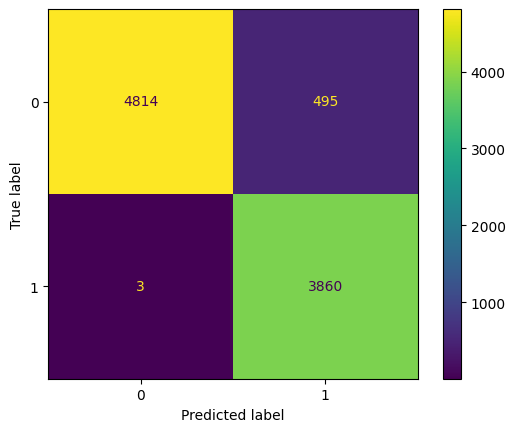


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5309
           1       0.89      1.00      0.94      3863

    accuracy                           0.95      9172
   macro avg       0.94      0.95      0.95      9172
weighted avg       0.95      0.95      0.95      9172


Accuracy: 94.5704317488007%
Precision: 88.6337543053961%
Recall: 99.92234015014238%


In [42]:
train_lg_classifier(BOW_2, np.asarray(corpus["CLASS"]))

/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Best parameters set {'C': 100.0} with accuracy 0.9192091549926102

Confusion matrix:


/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


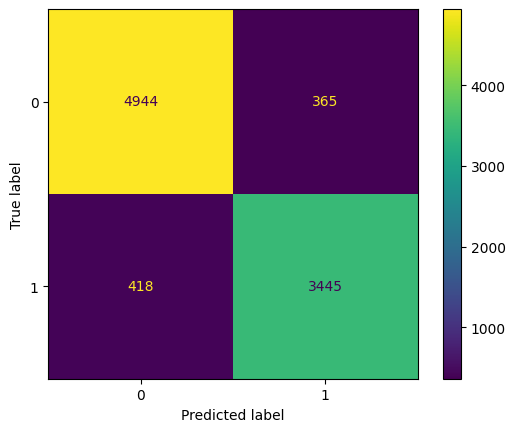


Classification report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5309
           1       0.90      0.89      0.90      3863

    accuracy                           0.91      9172
   macro avg       0.91      0.91      0.91      9172
weighted avg       0.91      0.91      0.91      9172


Accuracy: 91.46314871347579%
Precision: 90.41994750656168%
Recall: 89.17939425317111%


In [43]:
train_lg_classifier(BOW_3, np.asarray(corpus["CLASS"]))

/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/paul_d/Sources/yt_spam_scanner/model_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Best parameters set {'C': 10.0} with accuracy 0.9412176602986027

Confusion matrix:


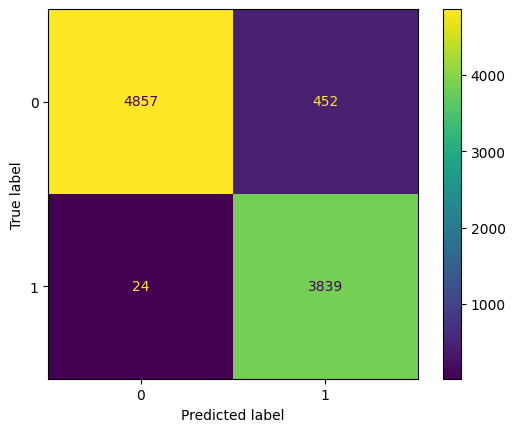


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5309
           1       0.89      0.99      0.94      3863

    accuracy                           0.95      9172
   macro avg       0.94      0.95      0.95      9172
weighted avg       0.95      0.95      0.95      9172


Accuracy: 94.81029219363279%
Precision: 89.4663248659986%
Recall: 99.37872120113902%


In [44]:
train_lg_classifier(tfidf_voc, np.asarray(corpus["CLASS"]))

### Load saved model

In [48]:
model_output_path = "saved_models/logisticregression_56-23.joblib"
clf = load_saved_model(model_output_path)
X_train, X_test, y_train, y_test = split_data(tfidf_voc, np.asarray(corpus["CLASS"]))

In [49]:
pd.DataFrame(clf.predict_proba(X_test[0]), columns=clf.classes_)

,0,1
0,0.921803,0.078197
